# **대표적인 오라클 Lock의 종류**

- **래치(Latch)**
  - SGA에 공유되어 있는 갖가지 자료구조를 보호할 목적으로 사용되는 가벼운 Lock.
  - 큐(Queue) 구조가 아님
- **버퍼 Lock**
  - 버퍼 블록에 대한 액세스를 직렬화.
- **라이브러리 캐시 Lock**
  - 라이브러리 캐시 오브젝트에 대한 핸들을 보호.
- **라이브러리 캐시 Pin**
  - 라이브러리 캐시 오브젝트의 실제 내용이 담긴 힙(HeaP)을 보호.
- **DML 테이블 Lock**
  - Enqueue Lock으로 구현.
- **DML 로우 Lock**
  - 로우 단위 Lock과 트랜잭션 Lock을 조합해서 구현.

# **래치(Latch)**

- cache buffers chains latch라고도 하며 버퍼 캐시 헤더 체인이 연결된 해시 버킷들을 하나의 래치가 관리

**래치 위치**

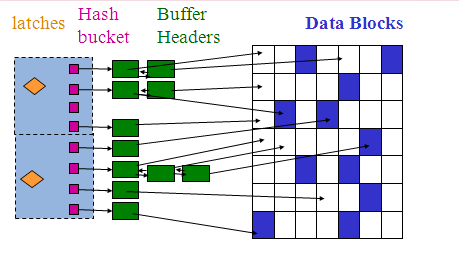

- Data Blocks는 버퍼 캐시 블록.
- Buffer Header는 버퍼 캐시 블록에 대한 메타 정보와 버퍼 메모리 영역의 실제 버퍼에 대한 포인터 값을 가짐.
- Hash Bucket은 블록의 주소(블록클래스)를 해시함수에 적용하여 같은 해시 값을 갖는 버퍼 헤더들이 체인 형태로 구성되어 있는 곳.
- 래치는 여러 사용자가 동시에 버퍼 블록에 접근 할 경우 정합성 문제 발생을 방지하기 위해 접근을 직렬화하기 위한 간단한 Lock을 의미하며 하나의 래치는 여러 해시 체인을 보호.

# **DML 테이블 Lock**

**Enqueue Lock**

- 테이블, 트랜잭션, 테이블스페이스, 시퀀스, Temp 세그먼트 등의 공유 리소스에 대한 액세스를 관리하는 Lock 메커니즘.
- DML 테이블 Lock은 래치와 달리 큐 구조를 사용하기 때문에 락의 대기 순서가 보장.
  - 대기자 큐에 가장 먼저 Lock 요청을 등록한 세션이 가장 먼저 Lock을 획득.
- Enqueue Lock으로 관리되는 공유 리소스에 대해 Lock을 획득하려면 먼저 Enqueue 리소스를 할당받아야 함.
  - 현재 할당된 Enqueue 리소스는 v$resource 뷰를 통해 확인할 수 있음.

> **Enqueue 리소스**
>
> 소유자(Owner), 대기자(Waiter) 목록을 관리할 수 있는 구조체.
>
> 각 Enqueue 리소스에 고유한 식별자(Type-ID1-ID2)를 부여.
>
> 식별자에서 Type은 2개 문자열('TX', 'TM', 'TS' 등)로 구성.
>
> 식별자에서 ID1, ID2에는 Lock 종류에 따라 다른 정보를 가짐.

**TM Lock**

- DML 테이블 Lock 실행시 걸리는 락.

- Enqueue로 구현.(TM Enqueue)
  - Enqueue 리소스 식별자에서 Type은 TM , ID1은 오브젝트ID ,ID2는 0으로 표시.
- enq: TM - contention 이벤트 발생
  - 선행 트랜잭션이 TM Lock을 해제하기를 기다리는 트랜잭션에서 발생하는 대기 이벤트.
- 현재 트랜잭션이 갱신 중인 테이블에 대한 테이블의 구조 변경을 방지.

- 로우 Lock 획득시 해당 테이블에 대한 테이블 Lock도 동시에 획득.

- 갱신중인 테이블에 대한 호환되지 않는 DDL 오퍼레이션을 방지.

- DML문 간에도 테이블 Lock을 이용해 동시성을 제어하는 경우도 있음.

- 병렬 DML 또는 Direct Path Insert 방식으로 작업을 수행하는 경우에도 TM Lock을 사용.

- 로우 Lock은 항상 Exclusive 모드이지만, 테이블 Lock에는 여러 가지 Lock 모드가 가용.

**명시적인 테이블 Lock 명령어 종류(Lock Table 명령어)**

1. RS 모드 (Row Share Table Locks)

```
LOCK TABLE EMP IN ROW SHARE MODE;
```

- row를 lock 시키고 lock된 테이블을 UPDATE 하고자 하는 것을 가리킨다.
- 모든 row를 SELECT 하려는 다른 트랜잭션을 허용.
- 동일 테이블에서 lock 되지 않은 row를 INSERT, UPDATE, DELETE 하는 다른 트랜잭션을 허용.
- 테이블에 대한 ROW SHARE, ROW EXCLUSIVE, SHARE, SHARE ROW EXCLUSIVE lock을 획득하려는 다른 트랜잭션을 허용.
- EXCLUSIVE 모드에서의 테이블 locking으로부터 다른 트랜잭션을 예방.
- select for update 명령에 의해 조건에 걸린 ROW 에 대해서는 TX LOCK이 걸려야하는데 이 때테이블 락으로 RS LOCK이 먼저 걸려야 함.

```
SELECT .. FROM .. WHERE .. FOR UPDATE OF .. ;
```

- 이 때 이 ROW 에 대해서 UPDATE, DELETE 를 실행할때는 에러는 나지 않지만 ,ROW 에 대해서는 TX LOCK 이 걸리므로 COMMIT 이나 ROLLBACK 할때까지 WAITING.

2. RX 모드 (Row Exclusive Table Lock)

```
LOCK TABLE EMP IN ROW EXCLUSIVE MODE ;
```

- insert, update, delete, merge 문을 위해 로우 Lock을 설정하려면 먼저 획득해야 하는 테이블락.
- ROW EXCLUSIVE LOCK lock이 걸린 transaction이 그 table에 있는 row들에 대해 하나 이상의 update를 수행하고자 하는 것을 가리킴.
  - 즉, row를 lock 시키고 테이블에서 row를 update 하고자 하는 것.
- 모든 row를 SELECT 하려는 다른 트랜잭션을 허용.
- 동일 테이블에서 lock 되지 않은 row를 INSERT, UPDATE, DELETE 하는 다른 트랜잭션을 허용.
- 테이블에 대한 ROW SHARE, ROW EXCLUSIVE lock을 획득하려는 다른 트랜잭션을 허용.
- 테이블에 대한 SHARE(S), ROW EXCLUSIVE lock(SRX), EXCLUSIVE lock(X) 을 획득하려는 다른 트랜잭션을 불허.
- 다음 명령어들에 의해 RX 모드 테이블 LOCK이 걸리기도 함.

```
UPDATE EMP SET ...;
INSERT INTO  EMP...;
DELETE FROM EMP ...;
```

> **RS, RX 간의 관계**
>
> - RS, RX 간에는 어떤 조합으로도 호환이 되므로 select for update나 DML문 수행시 이들간에 테이블 Lock에 의한 경합은 절대 발생하지 않음.
>
> - 다만, 같은 로우를 갱신하려 할 때 로우 Lock에 의한 경합은 발생.

3. S 모드 (share table lock)

```
LOCK TABLE EMP IN SHARE MODE;
```

- S LOCK 은 같은 테이블에 대해서 RS, S LOCK 만 가능.
  - 다른 트랜잭션들이 해당 table에 대한 query 수행 또는 SELECT … FOR UPDATE를 이용한 특정 row에 대한 lock을 거는 것을 허용.
  - 다른 트랜잭션들이 해당 테이블에 LOCK TABLE … IN SHARE MODE문으로 S lock을 거는 것을 허용.
- S LOCK 은 같은 테이블에 대해서 RX, SRX, X LOCK 을 걸 수 없음.
  - 다른 트랜잭션이 row를 INSERT, UPDATE, DELETE 하기 위해 RX, SRX, X LOCK 따위의 락을 거는 것을 불허.

4. SRX 모드(share row exclusive table lock)

```
LOCK TABLE EMP IN SHARE ROW EXCLUSIVE MODE;
```

- 테이블에 row를 INSERT, UPDATE, DELETE 하기 위해 걸린 테이블 Lock 모드.
- 동일 테이블에서 지정된 row를 QUERY 또는 SELECT … FOR UPDATE로 특정 row를 LOCK 하려는 다른 트랜잭션을 허용.(즉, RS LOCK 만 가능하다.)
  - 다른 트랜잭션의 table 갱신은 허용하지 않음.(즉 , RX, SRX, S, X LOCK 을 걸 수 없다.)
- 주어진 table에 대해 하나의 share row exclusive table lock만이 걸릴 수 있음.

5. X 모드(Exclusive Table Lock)

```
LOCK TABLE EMP IN EXCLUSIVE MODE;
```

- EXCLUSIVE lock을 건 트랜잭션이 table에 대한 access를 exclusive write로 허용하는 가장 제한적인 모드의 테이블 LOCK.
- 테이블에 row를 INSERT, UPDATE, DELETE 하기 위해 걸리는 가장 제한적인 테이블 Lock 모드.
- X LOCK 은 같은 테이블에서는 어떠한 LOCK 도 걸 수 없음.
  - 선행 트랜잭션과 호환되지 않는 모드로 테이블 Lock을 설정하려는 후행 트랜잭션은 대기하거나 작업을 포기.
- 동일 테이블에서 지정된 row를 QUERY하는 것에 대해서만 다른 트랜잭션을 허용.
- 다음과 같은 DDL 명령어 따위에 생기는 table 락.

```
DROP TABLE EMP;
ALTER TABLE EMP...;
```

**테이블 Lock에 대한 오해.1**

> FAQ 1) 테이블 전체에 Lock이 걸려서 다른 트랜잭션이 더는 레코드를 추가하거나 갱신하지 못하도록 막는 게 아닌가?
>
> 답변 ) update , insert , delete 등등 모든 DML 수행시 항상 Table Lock이 함께 설정.

**테이블 Lock에 대한 오해.2**

> FAQ 2) 테이블 Lock, Lock이라는 단어답게 진짜로 물리적으로 자물쇠처럼 잠그는 프로세스가 따로 있는거 아닌가?
>  
>  답변 ) 테이블락은 Lock을 획득한 선행 트랜젝션이 해당 테이블에서 현재 어떤 작업을 수행중인지 알리는 일종의 푯말(Flag)일 뿐.

> 즉, 푯말에 기록된 Lock 모드와 후행 트랜젝션이 현재 하려는 작업 내용에 따라 진행 여부가 결정.
> 여러 가지의 Lock 모드에 따라 후행 트랜잭션이 수행할 수 있는 작업의 범위가 결정되고 기다려야 한다면 TM Enqueue 리소스 대기자 목록에 Lock 요청을 등록하고 대기

**[예시] DDL문을 이용해 테이블 구조를 변경하려는 세션**

1. 해당 테이블에 TM Lock이 설정되어 있는지 먼저 확인.
2. TM Lock을 Row Exclusive(=SX) 모드로 설정한 트랜젝션이 하나라도 있다면 현재 테이블을 갱신중인 트랜젝션이 있다는 신호이므로 ORA-00054 메시지를 던지고 작업을 멈춤.
3. DDL문이 먼저 수행중일 경우는 DML문을 수행하려는 세션이 TX Lock을 얻으려고 대기.
4. 이 때 enq: TM - contention 대기 이벤트가 발생.

**대상 리소스가 사용중일 때 트랜잭션이 선택하는 진로의 종류**

- Lock을 얻고자 하는 리소스가 사용중일 때, 프로세스는 3가지 방법 중 하나를 선택.
- 보통은 진로가 결정되어 있지만 select for update 문 사용하여 사용자가 직접 선택하는 경우

1. Lock이 해제될 때까지 기다림.

```
select * from EMP for update;
```

2. 일정 시간만 기다리다 포기.

```
select * from EMP for update wait 3;
```

- 포기할 때 ORA-30006: resource busy; acquire with WAIT timeout expired 메시지를 던짐.
3. 기다리지 않고 작업을 포기.

```
select * from EMP for update nowait;
```

- 작업을 포기할 때 ORA-00054: resource busy and acquire with NOWAIT specified 메시지를 던짐.